In [1]:
import sys
import os
import numpy as np
import pandas as pd
import glob
import pickle
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inception_v3_preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from PIL import Image
from nltk import word_tokenize
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


### Load the whole description text set of Flicker8k 

In [2]:
def preprocess(t):
    ret = []
    for w in t.split(' '):
        if not w:
            continue
        # remove punctuation, number and special chars (e.g., #)
        # remove hanging word 's', 'a', 'b'
        w0 = ''.join(c for c in w if c.isalpha() or len(c) > 1)
        # convert to lower case
        ret.append(w0.lower())
        # return the description string with trailing spaces removed
    return (' '.join(ret)).rstrip()
    
def load_flick8r_descriptions():
    flick8r_token_file = 'Flickr8k_text/Flickr8k.token.txt'
    description_dict = {} 
    with open(flick8r_token_file, 'r') as f:
        token_doc = f.read()
        lines = token_doc.split('\n')
        for line in lines:
            if line:
                # get image id, relevant descriptions
                tokens = line.split()
                image_name = tokens[0].split('.')[0] #only get the file name, do not get the extension part
                image_desc = ' '.join(tokens[1:])
                if image_name not in description_dict:
                    description_dict[image_name] = list()
                # preprocess description
                description_dict[image_name].append(preprocess(image_desc))
    return description_dict 
description_dict = load_flick8r_descriptions()
print(description_dict['997338199_7343367d7f'])

['a person stands near golden walls', 'a woman behind a scrolled wall is writing', 'a woman standing near a decorated wall writes', 'the walls are covered in gold and patterns', 'woman writing on a pad in room with gold  decorated walls']


### Load the file names pre-assigned to each set of train/dev/test data

In [3]:
flicker8k_dataset = 'Flicker8k_Dataset/'
image_files = glob.glob(flicker8k_dataset + '*.jpg')
# define training, validation, and test set
# these are the image name list of each set
original_train_files = open('Flickr8k_text/Flickr_8k.trainImages.txt', 'r').read().strip().split('\n')
original_validation_files = open('Flickr8k_text/Flickr_8k.devImages.txt', 'r').read().strip().split('\n')
original_test_files = open('Flickr8k_text/Flickr_8k.testImages.txt', 'r').read().strip().split('\n')

print(len(original_train_files))

# TO-REMOVE: reduce the train and test dataset to bypass the memory error
# train_files = []
# test_files = []
# i = 0
# for file in original_train_files:
#     if i >= 2000:
#         break
#     train_files.append(file)
#     i = i + 1
# i = 0
# for file in original_test_files:
#     if i >= 1000:
#         break
#     test_files.append(file)
#     i = i + 1
# print(len(train_files))
# print(train_files[0])

train_files = original_train_files
test_files = original_test_files
print(len(train_files))
print(train_files[0])

6000
6000
2513260012_03d33305cf.jpg


### Function to load images and preprocess using vgg16 or inception v3

In [4]:
def load_images_vgg16(files):
    # files is the list of image file name in one set (either train or dev or test set)
    model = VGG16()
    images_dict = {}
    for name in files:
        img = image.load_img(flicker8k_dataset + name, target_size=(224, 224))
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = vgg16_preprocess_input(img)
        images_dict[name.split('.')[0]] = img
    return images_dict

def load_images_inception_v3(files):
    images_dict = {}
    for name in files:
        img = image.load_img(flicker8k_dataset + name, target_size=(299, 299))
        img = image.img_to_array(img)
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        img = inception_v3_preprocess_input(img)
        images_dict[name.split('.')[0]] = img
    return images_dict

### Function to extract features using vgg16 model (remove the last layer). Prepare the features of train dataset, dump to pickle file. This shell should be executed once.

In [5]:
# NOTE: run only once
def extract_features_vgg16(files, pickle_file_name):
    # files is the list of image file name in one set (either train or dev or test set)
    model = VGG16()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    images_dict = load_images_vgg16(files)
    features_dict = {}
    for key, img in images_dict.items():
        feature = model.predict(img, verbose=0)
        features_dict[key] = feature
    with open(pickle_file_name, "wb") as encoded_pickle:
        pickle.dump(features_dict, encoded_pickle)

#extract_features_vgg16(train_files, "encoded_train_images_vgg16.p")
#extract_features_vgg16(test_files, "encoded_test_images_vgg16.p")

In [6]:
def to_vocabulary(description_dict):
    vocab_set = set()
    for description in description_dict:
        vocab_set.update(nltk.work_tokenize(description))
    return vocab_set

### Prepare image features (encoding) and descriptions of train data set

In [7]:
def load_features_from_file(pickle_file_name):
    return pickle.load(open(pickle_file_name, 'rb'))
vgg16_train_features_dict = load_features_from_file('encoded_train_images_vgg16.p')
vgg16_test_features_dict = load_features_from_file('encoded_test_images_vgg16.p')

In [8]:
#vgg16_train_features_dict['997338199_7343367d7f']


In [9]:
def load_partly_descriptions(description_dict, files):
    # files is the list of image file name in one set (either train or dev or test set)
    # load descriptions for train or test set only
    result = {}
    for file in files:
        name = file.split('.')[0]
        result[name] = description_dict[name]
    return result
train_description_dict = load_partly_descriptions(description_dict, train_files)
test_description_dict = load_partly_descriptions(description_dict, test_files)

In [10]:
len(vgg16_train_features_dict)

6000

In [11]:
len(vgg16_test_features_dict)

1000

In [12]:
len(train_description_dict)

6000

In [13]:
len(test_description_dict)

1000

In [14]:
#train_description_dict['997338199_7343367d7f']

### For a set of data and the according descriptions, build a vocabulary set out of all descriptions ###
#### Utilize keras tokenizer ####
https://faroit.github.io/keras-docs/1.2.2/preprocessing/text/    
https://rdrr.io/cran/keras/man/texts_to_sequences.html

In [15]:
# convert a dictionary of clean descriptions to a list of descriptions
def get_all_desc(description_dict):
    all_desc = list()
    for key in description_dict.keys():
        [all_desc.append(d) for d in description_dict[key]]
    return all_desc
 
# fit a tokenizer given caption descriptions
# get the word counts of the vocabulary
def create_tokenizer(description_dict):
    lines = get_all_desc(description_dict)
    tokenizer = Tokenizer(char_level=False)
    tokenizer.fit_on_texts(lines)
    return tokenizer

# calculate the max length of descriptions
def max_sequence_length(description_dict):
    lines = get_all_desc(description_dict)
    return max(len(sequence.split()) for sequence in lines)

tokenizer = create_tokenizer(train_description_dict)


In [16]:
print(tokenizer.word_index)

{'a': 1, 'in': 2, 'the': 3, 'on': 4, 'is': 5, 'and': 6, 'dog': 7, 'with': 8, 'man': 9, 'of': 10, 'two': 11, 'white': 12, 'black': 13, 'boy': 14, 'are': 15, 'woman': 16, 'girl': 17, 'to': 18, 'wearing': 19, 'at': 20, 'people': 21, 'water': 22, 'brown': 23, 'red': 24, 'young': 25, 'an': 26, 'his': 27, 'blue': 28, 'dogs': 29, 'running': 30, 'through': 31, 'playing': 32, 'while': 33, 'down': 34, 'shirt': 35, 'ball': 36, 'standing': 37, 'little': 38, 'grass': 39, 'snow': 40, 'child': 41, 'person': 42, 'jumping': 43, 'over': 44, 'three': 45, 'sitting': 46, 'front': 47, 'field': 48, 'holding': 49, 'small': 50, 'yellow': 51, 'green': 52, 'group': 53, 'by': 54, 'up': 55, 'large': 56, 'one': 57, 'walking': 58, 'her': 59, 'men': 60, 'children': 61, 'air': 62, 'into': 63, 'near': 64, 'mouth': 65, 'beach': 66, 'jumps': 67, 'runs': 68, 'another': 69, 'for': 70, 'street': 71, 'from': 72, 'its': 73, 'riding': 74, 'stands': 75, 'bike': 76, 'girls': 77, 'as': 78, 'outside': 79, 'play': 80, 'rock': 81, '

In [17]:
tokenizer.texts_to_sequences(['a on dog'])

[[1, 4, 7]]

### Consider each description is a sequence of words ==> use texts_to_sequences to convert it to a sequence of numbers. The vocabulary that we build will be used to generate new caption also ###

Input 1: words sequence of description => RNN => words embedding    
Input 2: image features

### This function will take a whole day to finish for the training set of 6000 images. Need to apply multi-thread techique to reduce the runtime (use Ray package) 
### Deprecated

In [18]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, description_dict, train_features):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in description_dict.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
                max_length = max_sequence_length(train_description_dict)
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)
                # store
                X1.append(train_features[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# X1train, X2train, ytrain = create_sequences(tokenizer, train_description_dict, vgg16_train_features_dict)


### Use Ray to handle the parallel execution https://github.com/ray-project/ray

In [19]:
import ray
ray.init(redis_max_memory=20000000000, object_store_memory=20000000000)

2019-03-10 22:40:19,397	INFO node.py:278 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-03-10_22-40-19_58130/logs.
2019-03-10 22:40:19,518	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:12591 to respond...
2019-03-10 22:40:19,641	INFO services.py:396 -- Waiting for redis server at 127.0.0.1:32053 to respond...
2019-03-10 22:40:19,644	INFO services.py:798 -- Starting Redis shard with 20.0 GB max memory.
2019-03-10 22:40:19,688	WARNING services.py:1231 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 16811749376 bytes available. This may slow down performance! You may be able to free up space by deleting files in /dev/shm or terminating any running plasma_store_server processes. If you are inside a Docker container, you may need to pass an argument with the flag '--shm-size' to 'docker run'.
2019-03-10 22:40:19,689	INFO services.py:1360 -- Starting the Plasma object store with 20.0 GB memory using /tmp.



View the web UI at http://localhost:8889/notebooks/ray_ui.ipynb?token=6a3280ea413410c5e1cb7adc2c6075e57b64a8d99f7ac406



{'node_ip_address': None,
 'redis_address': '192.168.1.72:12591',
 'object_store_address': '/tmp/ray/session_2019-03-10_22-40-19_58130/sockets/plasma_store',
 'webui_url': 'http://localhost:8889/notebooks/ray_ui.ipynb?token=6a3280ea413410c5e1cb7adc2c6075e57b64a8d99f7ac406',
 'raylet_socket_name': '/tmp/ray/session_2019-03-10_22-40-19_58130/sockets/raylet'}

In [20]:
@ray.remote
def get_in_out_seqs(tokenizer, key, desc_list, max_length):
    k_in_out_seqs = []
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence

            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index) + 1)[0]
            # store
            k_in_out_seqs.append((key, in_seq, out_seq))
    return k_in_out_seqs


In [21]:
import gc
X1, X2, y = [], [], []
max_length = max_sequence_length(train_description_dict)

all_k_in_out_seq_ids = []
epoch_count = 0
COUNT_PER_EPOCH = 500
count = 0
# walk through each image identifier
for key, desc_list in train_description_dict.items():
    all_k_in_out_seq_ids.append(get_in_out_seqs.remote(tokenizer, key, desc_list, max_length))
    count += 1
    if count >= COUNT_PER_EPOCH:
        epoch_count += 1
        print("Epoch %d done" % epoch_count)
        all_k_in_out_seqs = ray.get(all_k_in_out_seq_ids)
        for k_in_out_seqs in all_k_in_out_seqs:
            for (key, in_seq, out_seq) in k_in_out_seqs:
                X1.append(vgg16_train_features_dict[key][0])
                X2.append(in_seq)
                y.append(out_seq)
        # reset
        all_k_in_out_seq_ids = []
        count = 0
        gc.collect()

X1 = np.array(X1)
X2 = np.array(X2)
y = np.array(y)

Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done
Epoch 5 done
Epoch 6 done
Epoch 7 done
Epoch 8 done
Epoch 9 done
Epoch 10 done
Epoch 11 done
Epoch 12 done


In [22]:
np.shape(X1)

(293517, 4096)

In [23]:
np.shape(X2)

(293517, 35)

In [24]:
np.shape(y)

(293517, 7591)

In [25]:
X1test, X2test, ytest = [], [], []
max_length = max_sequence_length(train_description_dict)

all_k_in_out_seq_ids = []
epoch_count = 0
COUNT_PER_EPOCH = 500
count = 0
# walk through each image identifier
for key, desc_list in test_description_dict.items():
    all_k_in_out_seq_ids.append(get_in_out_seqs.remote(tokenizer, key, desc_list, max_length))
    count += 1
    if count >= COUNT_PER_EPOCH:
        epoch_count += 1
        print("Epoch %d done" % epoch_count)
        all_k_in_out_seqs = ray.get(all_k_in_out_seq_ids)
        for k_in_out_seqs in all_k_in_out_seqs:
            for (key, in_seq, out_seq) in k_in_out_seqs:
                X1test.append(vgg16_test_features_dict[key][0])
                X2test.append(in_seq)
                ytest.append(out_seq)
        # reset
        all_k_in_out_seq_ids = []
        count = 0
        gc.collect()

X1test = np.array(X1test)
X2test = np.array(X2test)
ytest = np.array(ytest)

Epoch 1 done
Epoch 2 done


In [26]:
np.shape(X1test)

(48528, 4096)

In [27]:
np.shape(X2test)

(48528, 35)

In [28]:
np.shape(ytest)

(48528, 7591)

In [29]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder = add([se3, fe2])
    decoder = Dense(256, activation='relu')(decoder)
    outputs = Dense(vocab_size, activation='softmax')(decoder)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model


In [30]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7591


In [31]:
max_length = max_sequence_length(train_description_dict)
model = define_model(vocab_size, max_length)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# fit model
model.fit([X1, X2], y, epochs=10, verbose=2, callbacks=[checkpoint], validation_data=([X1test, X2test], ytest))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 256)      1943296     input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 35, 256)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_1 

In [32]:
from numpy import argmax
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text[9:]


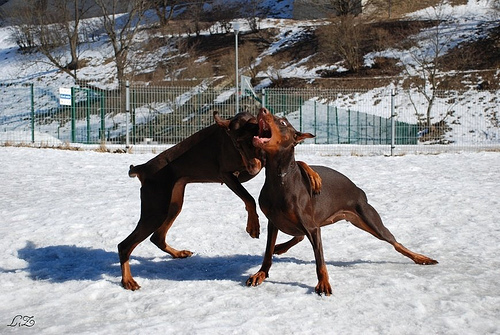

In [33]:
Image.open(flicker8k_dataset + '3385593926_d3e9c21170.jpg')

In [34]:
generate_desc(model, tokenizer, vgg16_test_features_dict['3385593926_d3e9c21170'], max_length)

'dog is running through the grass with a red toy in its mouth in the snow and a red ball in the background and a dog is in the background and a dog is running'

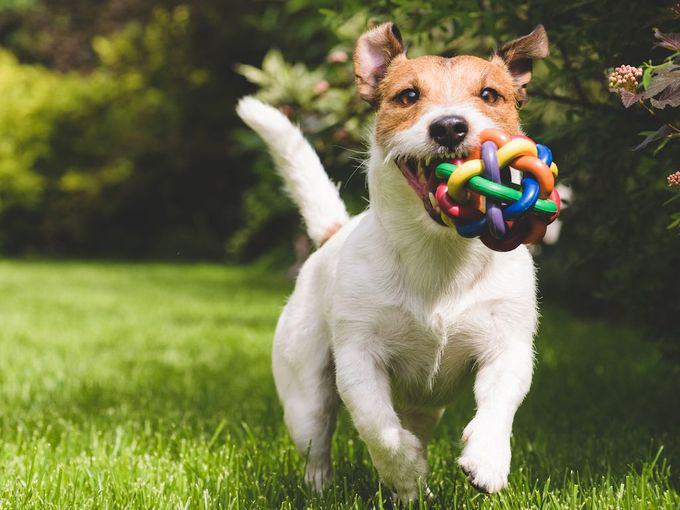

In [41]:
test_image_file = '/home/thy/Downloads/dog_1.jpg' 
Image.open(test_image_file)

In [42]:
def extract_features_test(filename):
    # load the model
    model = VGG16()
    # re-structure the model
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    # load the photo
    img = image.load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    img = image.img_to_array(img)
    # reshape data for the model
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    # prepare the image for the VGG model
    img = vgg16_preprocess_input(img)
    # get features
    feature = model.predict(img, verbose=0)
    return feature


In [43]:
photo = extract_features_test(test_image_file)
generate_desc(model, tokenizer, photo, max_length)

'dog is running through the grass with a red toy in its mouth in the snow and a red ball in the background and a dog is in the background and a dog is running'